Game
====

Toy Model
---------

Following the Maskin-Tirole paper, I consider a game where there are two
firms that each alternate in setting their prices.

Let each firm set price equal to one of $K$ potential prices, each firm
can only set its price in an alternating period, meaning that each time
a price is set, in the next period the opponent observes this price and
plays his best response to that price.

Competition is Bertrand where there is a linear demand function, and
there is zero marginal cost of production. First consider a simple unit
demand function, where monopoly profit would be given by:

%%latex
\begin{equation*}
  \Pi(x) = x(1-x)
\end{equation*}

Assume that there are $K=7$ potential prices indexed by $i$ given by
$p(i) = \frac{i}{6}$ for $i \in \{ 0, ..., 6\}$.

Profit for each firm in the market is determined by Bertrand pricing,
where the lowest price takes the entire market, and it is evenly split
if there is an equal price. Firms have no costs of production, so
charging a price of zero results in zero profit rather than a loss.

\begin{equation*}
  \pi(p_i,p_2) =
  \begin{cases}
    0 &\text{ if } p_1 > p_2\\
    \Pi(x) / 2  &\text{ if } p_1 = p_2\\
    \Pi(x) &\text{ if } p_1 < p_2
  \end{cases}
\end{equation*}

The relevant state variables for the firm choosing its price are the
current price by its opponent, their draws of $\epsilon$, and the
strategy being employed by its opponent. Since it makes its decision
before firm 2 has its draws revealed, their draws of $\epsilon$ are not
relevant.

Assume that this game is played on an infinite time horizon, and the
discount rate is given by $\delta$. When the opponents strategy is given
by $S$ and their price is $p_2$, the bellman equation is given by:

\begin{equation*}
  V(S, p_2, \epsilon) = \max_{i} \pi(p_i,p_2) + \epsilon_i + \delta \mathbb{E}_{S} \left[ \pi(
    p_i, p_j) + \delta \int_{\epsilon} V( S, p_j, \epsilon) \right]
\end{equation*}

Where $\epsilon_i$ is a type-1 extreme value random variable that is
unique for each price and $V(S,p,\epsilon)$ is the continuation value
when the opponent has price $p_j$ and strategy $S$. It is worth noting
that the same draw of $\epsilon_i$ is present in both $\pi$ functions in
the bellman equation, but the opponents actions will be probabilistic as
their draw of $\epsilon_j$ changes when they choose their optimal
strategy.

Let $p_{i,j}$ denote the probability that the opponent plays price $p_j$
when price $i$ is played. The payoff for paying price $p_i$ can be
written as:

\begin{align*}
  v_i &= \pi( p_i, p_2) + \epsilon_i + \delta \sum_{j=1}^K \left[ p_{i,j} \pi(p_i,
        p_j) + \delta \int_{\epsilon} V( S, p_j, \epsilon ) \right]\\
  v_i &= \bar{v}_i + \epsilon_i
\end{align*}

This bellman equation can be rewritten in the form

\begin{align*}
  V_{\theta}( x, \epsilon) &= \max_i \left[ u( x, i, \theta) + \epsilon(i) + \beta \int V_{\theta}( x', \epsilon)
                 \pi( dx', d\epsilon') \right]\\
  u( x, i, \theta) &= \pi( p_i, p_2) + \delta \sum_{j=1}^K p_{i,j} \pi(
                p_i, p_j)\\
  \beta &= \delta^2
\end{align*}

That is, if we consider the utility of choosing a price as the payout in
this period plus the discounted payoff in the previous period, then this
problem can be written in the same form as Harold Zurcher, only with a
larger choice set.

Define the expected value function as:

\begin{align*}
  EV( x, i) &= \int V( x', \epsilon') \pi( dx', d\epsilon') = \int_{\epsilon} \sum_{j=1}^K p_{i,j}
              V( S, p_j, \epsilon) dF_{\epsilon}\\
            &= \sum_{j=1}^K p_{i,j} \log \left( \sum_{k=1}^K \exp \left( \pi(
              p_k, p_j)  
              + \delta \sum_{l=1}^K p_{k,l} \pi( p_k, p_l) + \delta^2 EV( x, j ) \right)
              \right)\\  
\end{align*}


The ex-ante probabilities of choosing a price are given by the logit
formulas:

\begin{equation*}
  \Pr( p_i \vert S, p_2) = \frac{ \exp \left( \pi( p_i, p_2) + \delta \sum_{j=1}^K p_{i,j} \pi(
      p_i, p_j) + \delta^2 EV( x, i)  \right)}{\sum_{k=1} \exp \left( \pi( p_k,
      p_2) + \delta \sum_{j=1}^K p_{i,j} \pi( p_k, p_j) + \delta^2 EV( x, k) \right)}
\end{equation*} 

These probabilities are exactly the Frechet-Derivative needed for the
policy-function iterations as well as the mixing probabilities for the
best response function conditioned on an opponents strategy.

Implementation
==============

First we define the profit function for the firm given the price that
its opponent plays, and the variance of the T1EV term.

Note that we use the variance here since the T1EV is location scale, so
for some variance σ<sup>2</sup>, we may always write it as σ
ϵ<sub>i</sub>, where ϵ<sub>i</sub> is a standard T1EV random variable.
Therefore different variances in the error term are equivalent to
scaling the profit function by $\frac{1}{\sigma}$, and this requires
only solving the model for the unit T1EV distribution.

Variations between the models will come from changing the profit
function to different function forms.

Function: `profit` Output: current period profit for playing a price
given an opponents price Inputs:

-   pSelf: price charged by the firm making the choice
-   pOther: price charged by the opposing firm
-   scale: $\frac{1}{\sigma}$ as explained above

In [2]:
# This is the firms profit when playing against the opponent with price pOther
# scale is the inverse of the standard deviation of the T1EV error term.
@everywhere function profit(pSelf::Float64, pOther::Float64, scale::Float64)
    if pSelf > pOther
        return 0.0
    elseif pSelf < pOther
        return scale*pSelf*(1.0-pSelf)# Π(pSelf)
    else
        return scale*.5*pSelf*(1.0-pSelf)# Π(pSelf) / 2.0
    end
end

Backend
-------

Of course, the profit received by the firm is not only the profit in the
first period, but also the profit when the opponent reacts plus the
continuation value based on the opponents reaction. The payout function
captures the current period payout plus next periods expected payout.

Function: `PayOut`

Output: Non-random part of payout for choosing a price minus the
continuation value. In NFXP manual this would be:
$u( x_t, d_{t}, \theta)$. Inputs:

-   oppChoice: Current price set by opponent
-   myChoice: Potential price for current firm to choose
-   K: Size of price vector. Passed only for computational speed =
    length(p)
-   S: Matrix giving the strategy employed by the opposing firm. Each
    row of this matrix gives the probability of choosing a particular
    price conditioned on that row being chosen.
-   δ: Time discounting parameter
-   p: Vector containing the possible prices that can be played
-   scale: $\frac{1}{\sigma}$ as given above

In [3]:
@everywhere function PayOut( oppChoice::Int64, myChoice::Int64, K::Int64, S::Matrix{Float64},
                 δ::Float64, p::Vector{Float64}, scale::Float64)
    return profit( p[myChoice], p[oppChoice], scale) +
        δ*sum( S[myChoice,l]*profit( p[myChoice], p[l], scale) for l in 1:K)
end

One aspect that drastically improves performance is that the future
state (opponents price) is only dependent on the current price of the
firm, not on the opponents past. The Contraction mapping is carried out
via Rust's poly-algorithm using both value and policy-function
iteration.

Function: `DoValueIteration` Output: $T( EV_{\theta} )$, the value
function after one iteration if v were the value function.

Inputs:

-   S: Matrix giving the strategy employed by the opposing firm. Each
    row of this matrix gives the probability of choosing a particular
    price conditioned on that row being chosen.
-   v: Value function to be used in the value-function iteration
-   vNew: Placeholder for the new value function so new memory is
    allocated
-   vJ: Place-holder for the value of playing each move given each state
-   δ: Time discounting parameter
-   K: Size of price vector. Passed only for computational speed =
    length(p)
-   p: Vector containing the possible prices that can be played
-   maxHolder: place-holder for the maximum of vJ that is subtracted in
    order to prevent overflow error in exponentiation.
-   scale: $\frac{1}{\sigma}$ as given above

In [4]:
@everywhere function DoValueIteration( S::Matrix{Float64}, v::Vector{Float64},
                           vNew::Vector{Float64}, vJ::Matrix{Float64},
                           δ::Float64, K::Int64, p::Vector{Float64},
                           maxHolder::Vector{Float64}, scale::Float64)

    ## Note that the v defined here takes the place of $EV_{\theta}$
    ## in the nfxp manual in which the transition to a new state
    ## (opponents price) only depends on the choice made in the
    ## current period.
    for j in 1:K
        for k in 1:K
            # Each line is the payout in each period, as the opponent
            # reacts and then we get continuation value from next choice.

            vJ[k,j] = PayOut( j, k, K, S, δ, p, scale) + δ*δ*v[k]
        end
    end

    for j in 1:K
        maxHolder[j] = maximum(vJ[:,j])
    end
    for i in 1:K
        # We subract the max to prevent there ever being overflow
        # problems with exponentiating a large number
        vNew[i] = sum( S[i,j]*(log( sum( exp( vJ[k,j] - maxHolder[j] )
                                         for k in 1:K)) + maxHolder[j])
                       for j in 1:K)

    end
end

Function: `GetPolicy` Outputs: Matrix of strategies to play given a
value function for being in each state. This is used for policy-function
iteration as well as iterating for equilibrium strategies. Inputs:

-   v: Value function to be used in the value-function iteration
-   p: Vector containing the possible prices that can be played
-   S: Matrix giving the strategy employed by the opposing firm. Each
    row of this matrix gives the probability of choosing a particular
    price conditioned on that row being chosen.
-   vJ: Place-holder for the value of playing each move given each state
-   sNew: place-holder for the new strategy to prevent allocation in
    loops
-   maxHolder: place-holder for the maximum of vJ that is subtracted in
    order to prevent overflow error in exponentiation.
-   δ: Time discounting parameter
-   scale: $\frac{1}{\sigma}$ as given above
-   K: Size of price vector. Passed only for computational speed =
    length(p)

In [5]:
@everywhere function GetPolicy( v::Vector{Float64}, p::Vector{Float64},
                                S::Matrix{Float64}, vJ::Matrix{Float64},
                                maxHolder::Vector{Float64}, sNew::Matrix{Float64},
                                δ::Float64, scale::Float64, K::Int64)
    for i in 1:K
        for j in 1:K
            vJ[j,i] = PayOut( i, j, K, S, δ, p, scale) + δ*δ*v[j]
        end
        maxHolder[i] = maximum( vJ[:,i] )

        denom = sum( exp( vJ[j,i] - maxHolder[i] )  for j in 1:K)
        for j in 1:K
            sNew[i,j] = exp( vJ[j,i] - maxHolder[i] ) / denom
        end
    end
end

The actual solving of the contraction mapping is done via the function
DoContraction, it implements Rust's poly-algorithm using value function
iteration from the start, and continuing until the rate of convergence
is less than $\beta = \delta^2$. At this point it switches to Policy
function iteration due to its quadratic convergence rate.

Function: `DoCOntraction` Output: Optimal policy given a profit
function, and a strategy employed by an opponent. Inputs:

-   p: Vector containing the possible prices that can be played
-   S: Matrix giving the strategy employed by the opposing firm. Each
    row of this matrix gives the probability of choosing a particular
    price conditioned on that row being chosen.
-   sNew: place-holder for the new strategy to prevent allocation in
    loops
-   δ: Time discounting parameter
-   K: Size of price vector. Passed only for computational speed =
    length(p)
-   scale: $\frac{1}{\sigma}$ as given above

In [6]:
@everywhere function DoContraction( p::Vector{Float64}, S::Matrix{Float64}, sNew::Matrix,
                        δ::Float64, K::Int64, scale::Float64)

    vJ = zeros( K, K)
    v = zeros(K)
    vNew = ones( K )

    iterations = 0

    maxHolder = zeros(K)

    del = 1e5
    prevDel = 1e10

    β = δ*δ

    while( del / prevDel < β)
        v = copy(vNew)

        DoValueIteration( S, v, vNew, vJ, δ, K, p, maxHolder, scale)


        iterations += 1
        prevDel = del
        del = maximum( abs.(v - vNew) )
    end


    sNew = zeros(K,K)
    iterations = 0

    while( del > 1e-8 )
        GetPolicy( vNew, p, S, vJ, maxHolder, sNew, δ, scale, K)

        ## sNew is a KxK stochastic matrix so its determinant is quite small.
        F = I - (β)*sNew
        # This is the Newton-Kantorvich step
        v = v - F \ (v - vNew)

        #Do an extra VFI step to bound our error and smooth.
        DoValueIteration( S, v, vNew, vJ, δ, K, p, maxHolder, scale)

        del = maximum( abs.(v - vNew) )
        iterations += 1
    end
    return sNew
end

Function: `FindEquilibriumStrat` - Finds an equilibrium set of
strategies given some initial guess S.

Output: A $K \times K \times 2$ array containing an equilbirum strategy
for both players in the game, or all zeros if it fails to converge.
Inputs:

-   S: Initial guess array of the same size as the output array.
-   p: Vector containing the possible prices that can be played
-   K: Size of price vector. Passed only for computational speed =
    length(p)
-   δ: Time discounting parameter
-   scale: $\frac{1}{\sigma}$ as given above

In [7]:
@everywhere function FindEquilibriumStrat( S::Array{Float64,3}, p::Vector{Float64},
                               K::Int64, δ::Float64, scale::Float64 )
    sNew = zeros(K,K,2)

    del = 1e10
    iter = 0
    while( del > 1e-12 && iter < 250)
        sNew[:,:,1] = DoContraction( p, S[:,:,2], sNew[:,:,1], δ, K, scale )
        sNew[:,:,2] = DoContraction( p, S[:,:,1], sNew[:,:,2], δ, K, scale )

        del = maximum( abs.( sNew - S ))
        S = copy(sNew)

        iter += 1
    end
    if del > 1e-12
        return zeros(K,K,2)
    end

    return sNew
end

Front-End
---------

Function: `FindAllStrategies` - Repeatedly solves for the equilibrium
strategies of the players by randomly choosing N initial strategies.

Output: A vector of length N containing $K \times K \times 2$ arrays
each containing the equilibrium strategy for each random starting
location. Inputs:

-   K: Size of price vector. Passed only for computational speed =
    length(p)
-   S: Initial guess array of the same size as the output array.
    length(p)
-   δ: Time discounting parameter
-   p: Vector containing the possible prices that can be played
-   N: Number of random starting points to iterate on.
-   scale: $\frac{1}{\sigma}$ as given above

In [8]:
@everywhere function FindAllStrategies( K::Int64, δ::Float64, p::Vector{Float64}, N::Int64,
                                        scale::Float64)

    stratHolder = Vector{Array{Float64,3}}(undef,N)

    for i in 1:N
        # First things first generate a random starting strategy
        stratHolder[i] = rand(Uniform(), K, K, 2 )
        for z in 1:2
            for j in 1:K
                stratHolder[i][j,:,z] /= sum( stratHolder[i][j,:,z])
            end
        end
    end

    f(x) = FindEquilibriumStrat( x, p, K, δ, scale)
    stratHolder = pmap( f, stratHolder )
    return stratHolder
end

Function: `GetEquilibriumStrategies` - This takes the Array produced by
`FindAllStrategies` and returns the unique converged equilibrium
strategies. It is possible that it returns an empty array.

Output: An array of $K \times K \times 2$ arrays each containing an
equilbirum strategy for both players in the game. This can be empty if
no strategies converge. Inputs:

-   K: Size of price vector. Passed only for computational speed =
    length(p)
-   S: Initial guess array of the same size as the output array.
    length(p)
-   δ: Time discounting parameter
-   p: Vector containing the possible prices that can be played
-   N: Number of random starting points to iterate on.
-   scale: $\frac{1}{\sigma}$ as given above

In [9]:
function GetEquilibriumStrategies( K::Int64, δ::Float64, p::Vector{Float64}, N::Int64,
                             scale::Float64 )

    stratHolder = FindAllStrategies( K, δ, p, N, scale )

    rev = zeros(K,K,2)
    uniqueStrats = []
    for strat in stratHolder
        equal = false
        rev[:,:,1] = strat[:,:,2]
        rev[:,:,2] = strat[:,:,1]
        for s in uniqueStrats
            diff = min( maximum( abs.( s - strat)), maximum( abs.( s - rev)) )
            if diff < 1e-5
                equal = true
                break
            end
        end
        if !equal
            push!( uniqueStrats, strat )
        end
    end

    zorp = zeros(K,K,2)
    return filter( x -> x != zorp, uniqueStrats)
end

GetEquilibriumStrategies (generic function with 1 method)

Function `SimStrategies` - Given a strategy, simulates play over Nsim
periods. Output: $Nsim \times 3$ matrix whose rows represent time
periods, first column is the market price, second is firm ones price,
and third is firm 2's price. Inputs:

-   Nsim: Integer reprsenting the number of time periods to simulate
-   S: A $K \times K \times 2$ array containing an equilbirum strategy
    for both players

in the game

In [10]:
function SimStrategies( Nsim::Int64, S::Array{Float64,3} )
    cFlips = rand( Uniform(), Nsim)
    cS = zeros(K,K,2)
    for i in 1:K
        for j in 1:K
            for k in 1:2
                cS[i,j,k] = sum( S[i,1:j,k])
            end
        end
    end

    prices = Vector{Int64}(undef,2)
    prices[:] .= 7

    priceHistory = zeros(Nsim,3)

    counts = Vector{Int64}(undef,K)
    counts .= 0

    switcher = 1
    for i in 1:Nsim
        opp = (switcher)%2+1
        for j in 1:K
            # This is just the inverse cdf ~ Uniform
            if( cFlips[i] < cS[prices[opp],j,switcher] )
                prices[switcher] = j
                break
            end
        end
        switcher = opp
        priceHistory[i,1] = min( prices[1], prices[2])
        priceHistory[i,2] = prices[1]
        priceHistory[i,3] = prices[2]
        counts[min( prices[1], prices[2])] += 1
    end
    return priceHistory
end

SimStrategies (generic function with 1 method)

Function: `PlotPicture` - Plots the market history with some settings
and saves it to file $filename$ Output: reference to the displayed plot
Inputs:

-   Nsim: Number of periods to simulate
-   zone: Range of time periods to show in the plot
-   titlePlot: Title of the Plot
-   monopoly: Bool whether or not to print the dashed monopoly price
-   marketPrice: Bool whether or not to display the market price
-   S: A $K \times K \times 2$ array containing an equilbirum strategy
    for both players

in the game

-   filename: Filename for saving the image

In [11]:
 function PlotPicture( Nsim::Int64, zone, titlePlot, monopoly, marketPrice, S, filename)
    
      priceHistory = SimStrategies( Nsim, S)
    
      plt = plot( zone, priceHistory[zone,2], alpha=.5, label="Firm 1 Price",
            title=titlePlot)
      plot!( zone, priceHistory[zone,3], alpha=.5, label="Firm 2 Price")
      if monopoly
          plot!( zone, ones(101)*4, alpha= .3, linestyle=:dash, label="Monopoly Price",
                 color = :blue)
      end
      if marketPrice
          plot!( zone, priceHistory[zone,1], alpha= 1.0, 
                label="Market Price", color=:black)
      end
    
      #savefig(filename)
      return plt
  end

PlotPicture (generic function with 1 method)

Helper Functions For Display
----------------------------

This section is mostly helper functions that allow for pretty output and
visualization of the tables used in the results section. These should be
ignored as they only clean output for display.

In [24]:
  using Printf
  using Latexify

  function cln( x::Float64 )
      return replace(@sprintf("%.3g",x), r"e[\+]?([\-0123456789]+)" => s" \\times 10^{\1}")  
  end

  function cln( x::String )
      return x
  end

  function latex( x )
      return replace(replace( latexify( x,latex=false, env=:table ), "tabular" => "array" ), r"\{c+\}" => s"" )
    
  end

function showMe( x )
    display( "text/latex", latex( x) )
end


  function CleanStrat( S::Array{Float64,3}, K::Int64 )
      outputStrat =  vcat( 
          hcat( "Player 1:", repeat( [""], 1, K-1 )),
          S[:,:,1], repeat( [""], 2, K),
          hcat( "Player 2:", repeat( [""], 1, K-1 )),
          S[:,:,2] )

      return cln.( outputStrat )
  end

  function BuildStratProfile( strats, K::Int64)
      output = ["#Strats: " string(length( strats )) repeat( [""], 1, K-2)]

      output = vcat( output, CleanStrat( strats[1], K ) )
      #println( length( strats))
      #output = CleanStrat( strats[1], K )
      if( length( strats) > 1 && length( strats ) < 10 )
          for i in 2:length(strats)
              output = vcat( output, repeat( [""], 4, K))
              output = vcat( output, CleanStrat( strats[i], K ) )
          end
      elseif length( strats ) >= 10
          for i in 2:5
              output = vcat( output, repeat( [""], 4, K))
              output = vcat( output, CleanStrat( strats[i], K ) )
          end
          output = vcat( output, hcat( "...", repeat( [""], 1, K-1 )))
          for i in 1:5
              output = vcat( output, repeat( [""], 4, K))
              output = vcat( output, CleanStrat( strats[end-i+1], K ) )
          end
      end
      return output
  end


  function ExamineScaleRange( scales::Vector{Float64}, K::Int64, δ::Float64,
                              p::Vector{Float64}, N::Int64)

      bigMat = zeros(length(scales),6)

      for (i,s) in enumerate(scales)
          sim = GetEquilibriumStrategies( K, δ, p, N, s )
          bigMat[i,1] = s
          bigMat[i,2] = length(sim)
          for strat in sim
              pHist = SimStrategies(10000, sim[1])
              bigMat[i,3] += mean( pHist[:,1])
              bigMat[i,4] += std( pHist[:,1])
              bigMat[i,5] += std( pHist[:,2])
              bigMat[i,6] += std( pHist[:,3])
          end
          if length( sim ) >= 1
              bigMat[i,3:6] ./= length(sim)
          end
      end

      return cln. (vcat( ["\\text{Scale}" "\\text{Num Strategies}" "\\text{Mean Market Price}" "\\text{Market Price SD}" "\\text{Player 1 SD}" "\\text{Player 2 SD}"], bigMat ))
    #return cln.( bigMat )
  end

using Distributed
using SharedArrays
@everywhere using Distributions
@everywhere using LinearAlgebra
using Plots

pyplot()



@everywhere K = 7
@everywhere N = 100
@everywhere δ = .95

#Prices given by p(i) = i / 6
@everywhere p = convert( Vector{Float64}, 0:(K-1) ) / (K-1)

Maskin-Tirole Dynamic Bertrand
==============================

First set the profit function for this model, which is Bertrand pricing

In [85]:
@everywhere function profit(pSelf::Float64, pOther::Float64, scale::Float64)
    if pSelf > pOther
        return 0.0
    elseif pSelf < pOther
        return scale*pSelf*(1.0-pSelf)# Π(pSelf)
    else
        return scale*.5*pSelf*(1.0-pSelf)# Π(pSelf) / 2.0
    end
end


First I consider strategies for different variances in the error, one where the error term has a small effect, so that probabilities that would be zero without the error are driven very small. This can be thought of as close to the limit of the model as we can reach. 

The large variance version of the model features probabilities of actions that would never be played at roughly 2%. This means that there is a very real possibility of deviations, and we would expect the price to be much more volatile as firms are consistnetly undercutting each other. 

In [86]:
equiStrats = GetEquilibriumStrategies( K, δ, p, N, 50.0 )

showMe( BuildStratProfile( equiStrats, K )) 

In [90]:
largeVarianceStrat = GetEquilibriumStrategies( K, δ, p, N, 10.0 )

showMe( BuildStratProfile( largeVarianceStrat, K )) 

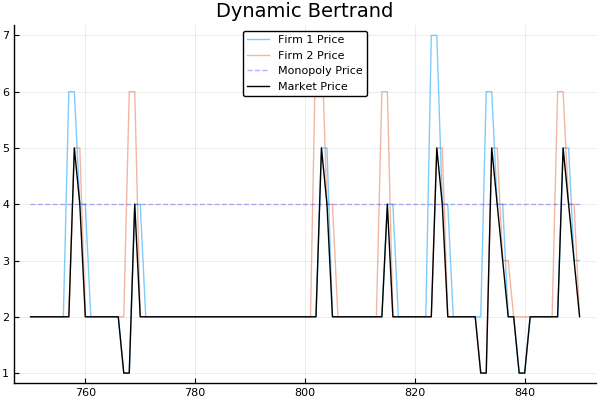

In [88]:
PlotPicture(1000, 750:850, "Dynamic Bertrand", true, true, equiStrats[1], "DynBertrand.pdf")

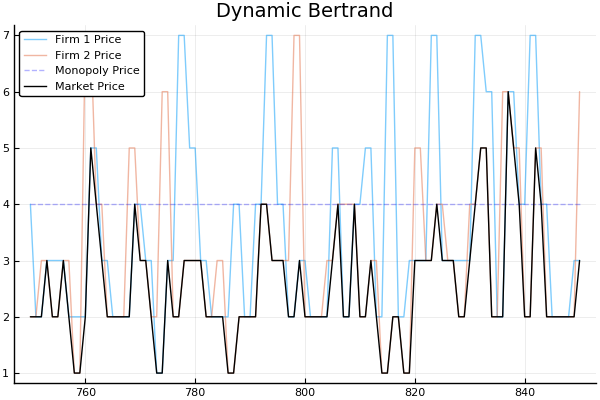

In [91]:
PlotPicture(1000, 750:850, "Dynamic Bertrand", true, true, largeVarianceStrat[1], "DynBertrand.pdf")

We can explore how the number of strategies as well as the volatility in the market changes as the scale increases. This table shows the volatility of all three prices over time, as well as the number of equilibrium strategies. 

As some attempt at a measure of consumer welfare, I have the mean market price, which is increasing in the variance of the market. (High scale means low variance.) I don't believe that this is a general result, and just happens to occur because the kinked demand outcome of a price of 2 is very nice for consumers in this set up. 

In [25]:
N = 100
scales = [0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0]

showMe(ExamineScaleRange( scales, K, δ, p, N ))

Logit Style Demand
==================


First Look at the market behavior when there are two players with slightly differentiated goods such that they face logit demand rather than Bertrand Demand. Later we will consider when there is some cost of being the high cost producer

In [92]:
@everywhere function profit(pSelf::Float64, pOther::Float64, scale::Float64)
    return scale*pSelf * ( 1.0 ) / ( exp( 2.5*pSelf ) + 1.0 + exp( 15.0*(pSelf - pOther) ))
end

In [46]:
equiStrats = GetEquilibriumStrategies( K, δ, p, N, 20.0 )

showMe(BuildStratProfile( equiStrats, K ))

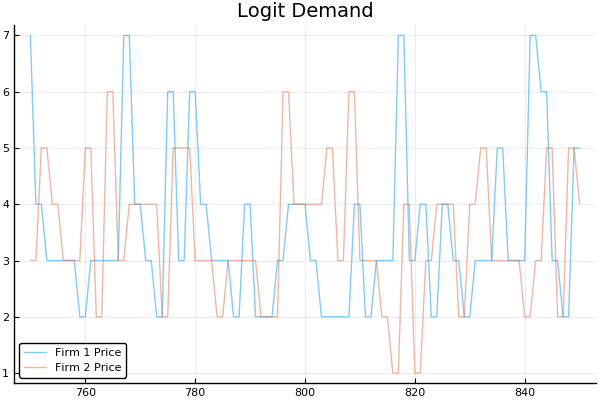

In [47]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, equiStrats[1], "logit.pdf")

However, when the variance decreases (increasing the scale parameter) we see that we switch away from the undercutting behavior, and move towards the kinked demand equilibrium. 

In [48]:
largeVarianceStrat = GetEquilibriumStrategies( K, δ, p, N, 50.0 )

showMe( BuildStratProfile( largeVarianceStrat, K )) 

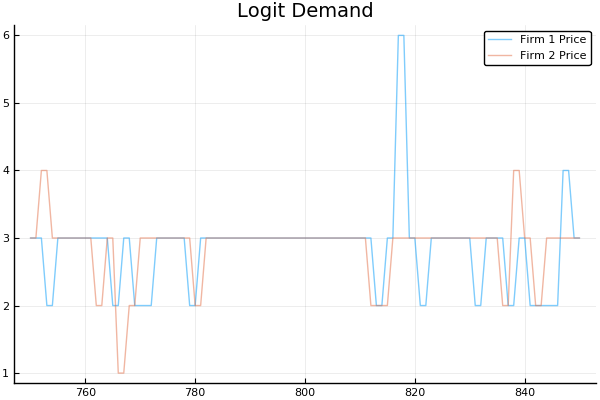

In [49]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, largeVarianceStrat[1], "logit.pdf")

In [94]:
N = 1000
scales = [0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0]

showMe(ExamineScaleRange( scales, K, δ, p, N ))

Low Price Producer Premium
==================

Consider a reduced form way of representing the benefit of being the low price producer in the market. There is a discontinuity in demand when your price exceeds your opoonents shown by the $pSelf > pOther$ component of the demand function.

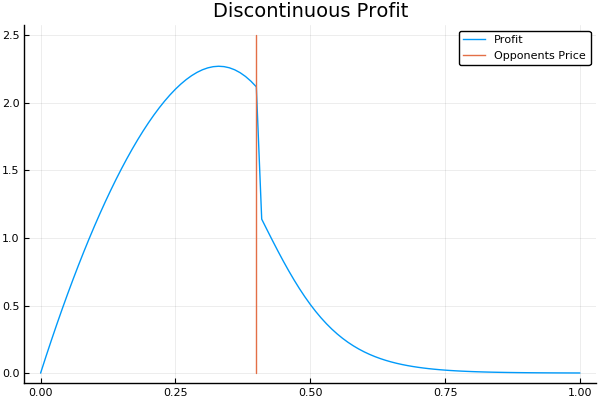

In [95]:
@everywhere function profit(pSelf::Float64, pOther::Float64, scale::Float64)
    return scale*pSelf * ( 1.0 ) / ( exp( 2.5*pSelf ) + 1.0 + exp( 15.0*(pSelf - pOther) + 1.5*(pSelf > pOther) ))
end
x = 0.0:.01:1.0
plot( x, profit.( x, .4, 25.0 ), label="Profit", title="Discontinuous Profit")
plot!( [.4,.4], [0.0,2.5], label="Opponents Price")

In [75]:
highVarStrat = GetEquilibriumStrategies( K, δ, p, N, 25.0 )

showMe(BuildStratProfile( highVarStrat, K ))

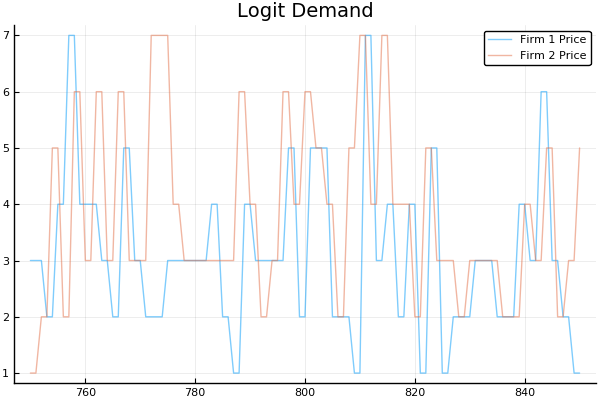

In [76]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, highVarStrat[1], "logit.pdf")

In [82]:
equiStrats = GetEquilibriumStrategies( K, δ, p, N, 50.0 )

showMe(BuildStratProfile( equiStrats, K ))

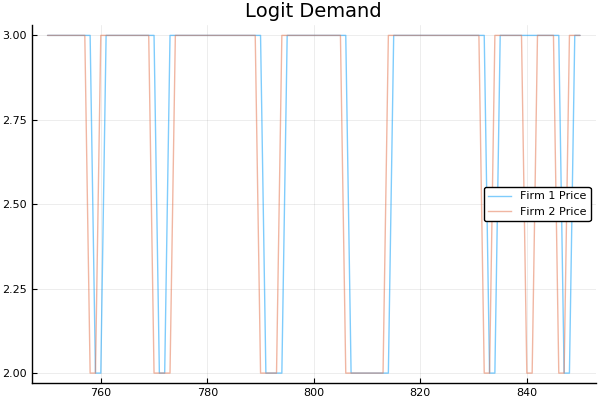

In [83]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, equiStrats[1], "logit.pdf")

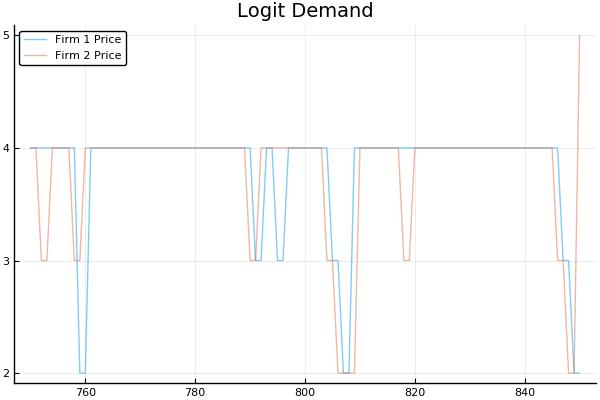

In [84]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, equiStrats[2], "logit.pdf")

Here we can see that we break the pattern of only having a single equilibrium strategy, and the equilbiria seem to change as the variance in the error decreases. As the opponent becomes more predictable, prices stabilize towards their static optimum, and then when there is a deviation, they undercut until the firm returns to the kinked demand behavior, not unlike a trigger strategy. 

In [96]:
N = 1000
scales = [0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0]

showMe(ExamineScaleRange( scales, K, δ, p, N ))


Note that when there are many more starting points explored, the number of strategies increases for large scale. This is simply kept low for computational reasons in the display

Large Kink
==================

Increasing the size of the kink in the demand does not really do anything to change the behavior of the model. The determination of the kinked demand versus edgeworth cycle appears to be caused by the variance in the model.

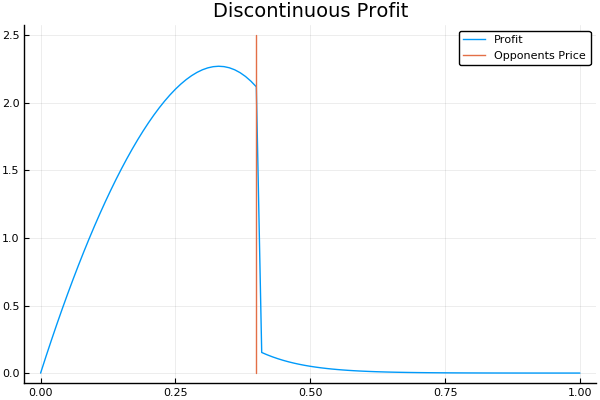

In [97]:
@everywhere function profit(pSelf::Float64, pOther::Float64, scale::Float64)
    return scale*pSelf * ( 1.0 ) / ( exp( 2.5*pSelf ) + 1.0 + exp( 15.0*(pSelf - pOther) + 4.0*(pSelf > pOther) ))
end
x = 0.0:.01:1.0
plot( x, profit.( x, .4, 25.0 ), label="Profit", title="Discontinuous Profit")
plot!( [.4,.4], [0.0,2.5], label="Opponents Price")

In [68]:
highVarStrat = GetEquilibriumStrategies( K, δ, p, N, 25.0 )

showMe(BuildStratProfile( highVarStrat, K ))

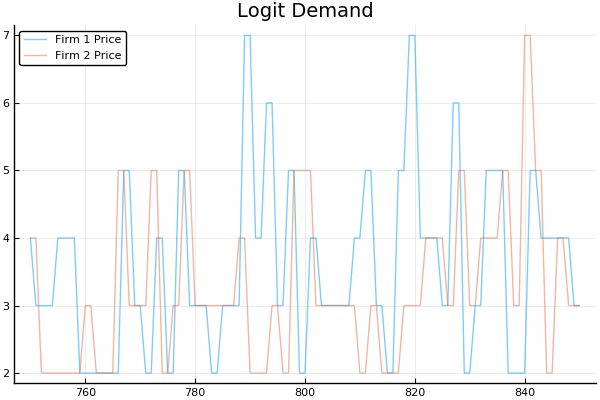

In [70]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, highVarStrat[1], "logit.pdf")

In [71]:
equiStrats = GetEquilibriumStrategies( K, δ, p, N, 50.0 )

showMe(BuildStratProfile( equiStrats, K ))

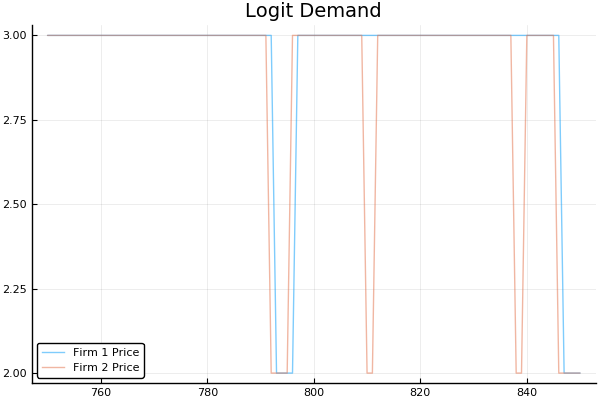

In [72]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, equiStrats[1], "logit.pdf")

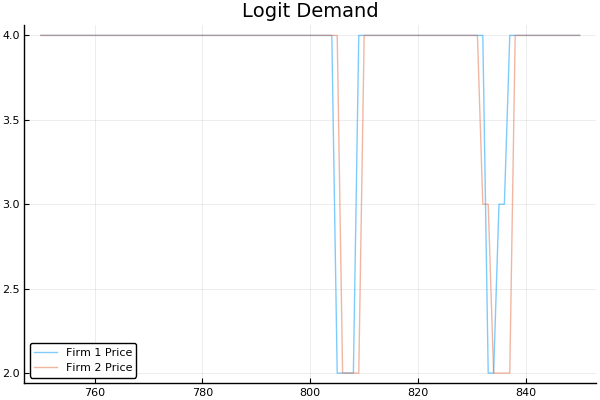

In [73]:
PlotPicture(1000, 750:850, "Logit Demand", false, false, equiStrats[2], "logit.pdf")

The behavior under the large kink does not appear to be visually different from there being a small kink in the demand, indicating that its size is not that relevant to behavioral predictions. 